# Clustering analysis

For details of the preprocessing steps performed on the raw data, please see [Lee et al. (2024)](https://doi.org/10.7554/eLife.89950.3). Most of this analysis is inspired by [Namboodiri et al. (2019)](https://doi.org/10.1038/s41593-019-0408-1).

In [1]:
import sys
import os
import numpy as np
from sklearn.decomposition import PCA

src_path = os.path.abspath(os.path.join('..', 'src'))
if src_path not in sys.path:
    sys.path.append(src_path)

from clustering import (
    get_n_retained_pc,
    scree_plot,
    grid_search_spectral_clustering,
    reorder_cluster_labels,
    get_label_lesion_identity,
    plot_cluster_pie,
    plot_clustered_heatmaps,
    plot_average_responses
    )

## Load and reduce the dimensionality of the data

The `population_activity.npy` contains the concatenated mean activity of hit and miss trials for each neuron.
- For each neuron, the mean activity was obtained by taking the mean across all the stimulus trials in a given session separately for hit and miss trials.
- The shape of this data is neuron x time point (i.e. imaging frames for hit and miss trials).
    - There are 193 imaging frames per trial in our experiments, so the number of time points for hit and miss trials concatenated are 386 frames.
    - There are 2649 neurons in this dataset in total, the first 1697 neurons were from non-lesioned, and the following 952 neurons were from lesioned.

In [2]:
population_activity = np.load('../data/clustering/population_activity.npy')
population_activity.shape # first 1697 non-lesioned, then 952 lesioned

(2649, 386)

Parameters specific to our two-photon calcium imaging experiments

In [ ]:
N_NEURONS_NON_LESIONED = 1697 # Number of neurons from non-lesioned
TRIAL_TYPES = ['Hit', 'Miss'] # Trial types included in the `population_activity` array
N_IMAGING_FRAMES_PER_TRIAL = 193  # Number of imaging frames per trial
TRIAL_DURATION_SEC = 7  # Duration of a trial (seconds)
PRE_STIM_DURATION_SEC = 2  # Duration of the pre-stimulus period (seconds)
FRAME_RATE = N_IMAGING_FRAMES_PER_TRIAL / TRIAL_DURATION_SEC  # Imaging frame rate (frames per second)
N_PRE_STIM_FRAMES = int(PRE_STIM_DURATION_SEC * FRAME_RATE) # Number of frames in pre-stimulus period

To reduce the dimensionality of this dataset before clustering, we perform principal components analysis (PCA) along the time axis to capture the temporal response profile of each neuron and determine the number of PCs to keep using the elbow method.

Total number of PCs: 386
Number of PCs to keep: 9


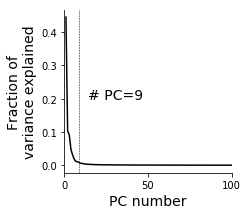

In [4]:
# PCA along time axis
pca = PCA(n_components=population_activity.shape[1], whiten=True)
pca_data = pca.fit_transform(population_activity)

# Get the number of PCs to keep, using the elbow method
num_retained_pcs = get_n_retained_pc(pca)
fig, ax = scree_plot(pca, num_retained_pcs);

## Clustering
While clustering is a useful approach for organizing and visualizing the activity of large and heterogeneous populations of neurons, we need to be mindful that, given continuous distributions of response properties, the locations of cluster boundaries can be somewhat arbitrary and/or reflect idiosyncrasies of the chosen method and thus vary from one algorithm to another.

We employed an approach inspired by [Namboodiri et al. (2019)](https://doi.org/10.1038/s41593-019-0408-1) because it is thought to produce stable results in high-dimensional neural data [Hirokawa et al. (2019)](https://doi.org/10.1038/s41586-019-1816-9). 

### Grid search for spectral clustering

In [5]:
# Get the data after dimensionality reduction
retained_pc_data = pca_data[:, :num_retained_pcs] 

# The parameters we want to try with spectral clustering
param_grid = {
    'n_clusters': np.arange(2, 12),
    'n_nearest_neighbors': np.arange(100, 900, 100)
}

# Perform spectral clustering with different parameters
clustering_results = grid_search_spectral_clustering(
    retained_pc_data=retained_pc_data,
    param_grid=param_grid,
    random_state=0,
    results_save_path='../results/clustering/silhouette-scores.csv'
)

21:40 - INFO - Score = 0.167 for # clusters = 2, # nearest neighbors = 100
21:40 - INFO - Score = 0.176 for # clusters = 2, # nearest neighbors = 200
21:40 - INFO - Score = 0.183 for # clusters = 2, # nearest neighbors = 300
21:40 - INFO - Score = 0.186 for # clusters = 2, # nearest neighbors = 400
21:41 - INFO - Score = 0.188 for # clusters = 2, # nearest neighbors = 500
21:41 - INFO - Score = 0.189 for # clusters = 2, # nearest neighbors = 600
21:41 - INFO - Score = 0.190 for # clusters = 2, # nearest neighbors = 700
21:41 - INFO - Score = 0.190 for # clusters = 2, # nearest neighbors = 800
21:41 - INFO - Score = 0.146 for # clusters = 3, # nearest neighbors = 100
21:42 - INFO - Score = 0.160 for # clusters = 3, # nearest neighbors = 200
21:42 - INFO - Score = 0.168 for # clusters = 3, # nearest neighbors = 300
21:42 - INFO - Score = 0.171 for # clusters = 3, # nearest neighbors = 400
21:42 - INFO - Score = 0.173 for # clusters = 3, # nearest neighbors = 500
21:43 - INFO - Score = 0.

In [7]:
# Get the best model (i.e. the one with the highest silhouette score)
best_model_result = clustering_results[clustering_results['silhouette_score']==clustering_results['silhouette_score'].max()]
assert len(best_model_result) == 1
best_model_result.drop(columns='cluster_labels')

,n_clusters,n_nearest_neighbors,silhouette_score
66,10,300,0.22581


### Re-order cluster labels
Since the clustering labels are arbitrary, we reorder cluster labels based on the sorted average response in a post-stimulus window.

In [8]:
labels_from_model = best_model_result['cluster_labels'].values[0]

cluster_labels = reorder_cluster_labels(
    labels_from_model=labels_from_model,
    population_activity=population_activity,
    n_pre_stim_frames=N_PRE_STIM_FRAMES,
    post_stim_window=int(4 * FRAME_RATE),
    save_path='../results/clustering/cluster_labels.npy'
)

21:58 - INFO - Results saved to ../results/clustering/cluster_labels.npy


## Visualisation

In [9]:
cluster_labels = np.load('../results/clustering/cluster_labels.npy')

Visualise the number of proportion of neurons from 'Non-lesioned' vs 'Lesioned' in each cluster

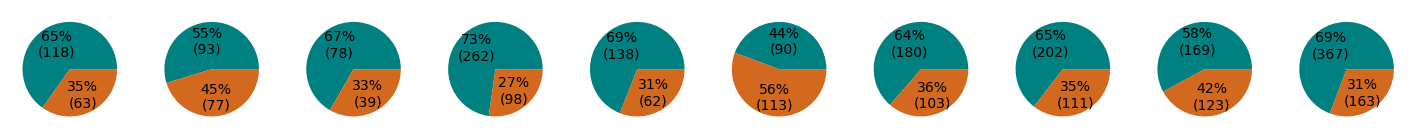

In [10]:
label_lesion_identity = get_label_lesion_identity(
    cluster_labels=cluster_labels,
    n_non_lesioned=N_NEURONS_NON_LESIONED
    )

colors = {'Non-lesioned': 'teal', 'Lesioned': 'chocolate'}

fig, axes = plot_cluster_pie(
    cluster_labels=cluster_labels,
    label_lesion_identity=label_lesion_identity,
    colors=colors)

Visualise individual neuronal responses for each cluster

/home/tai-yinglee/anaconda3/envs/dj_pdupdate/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


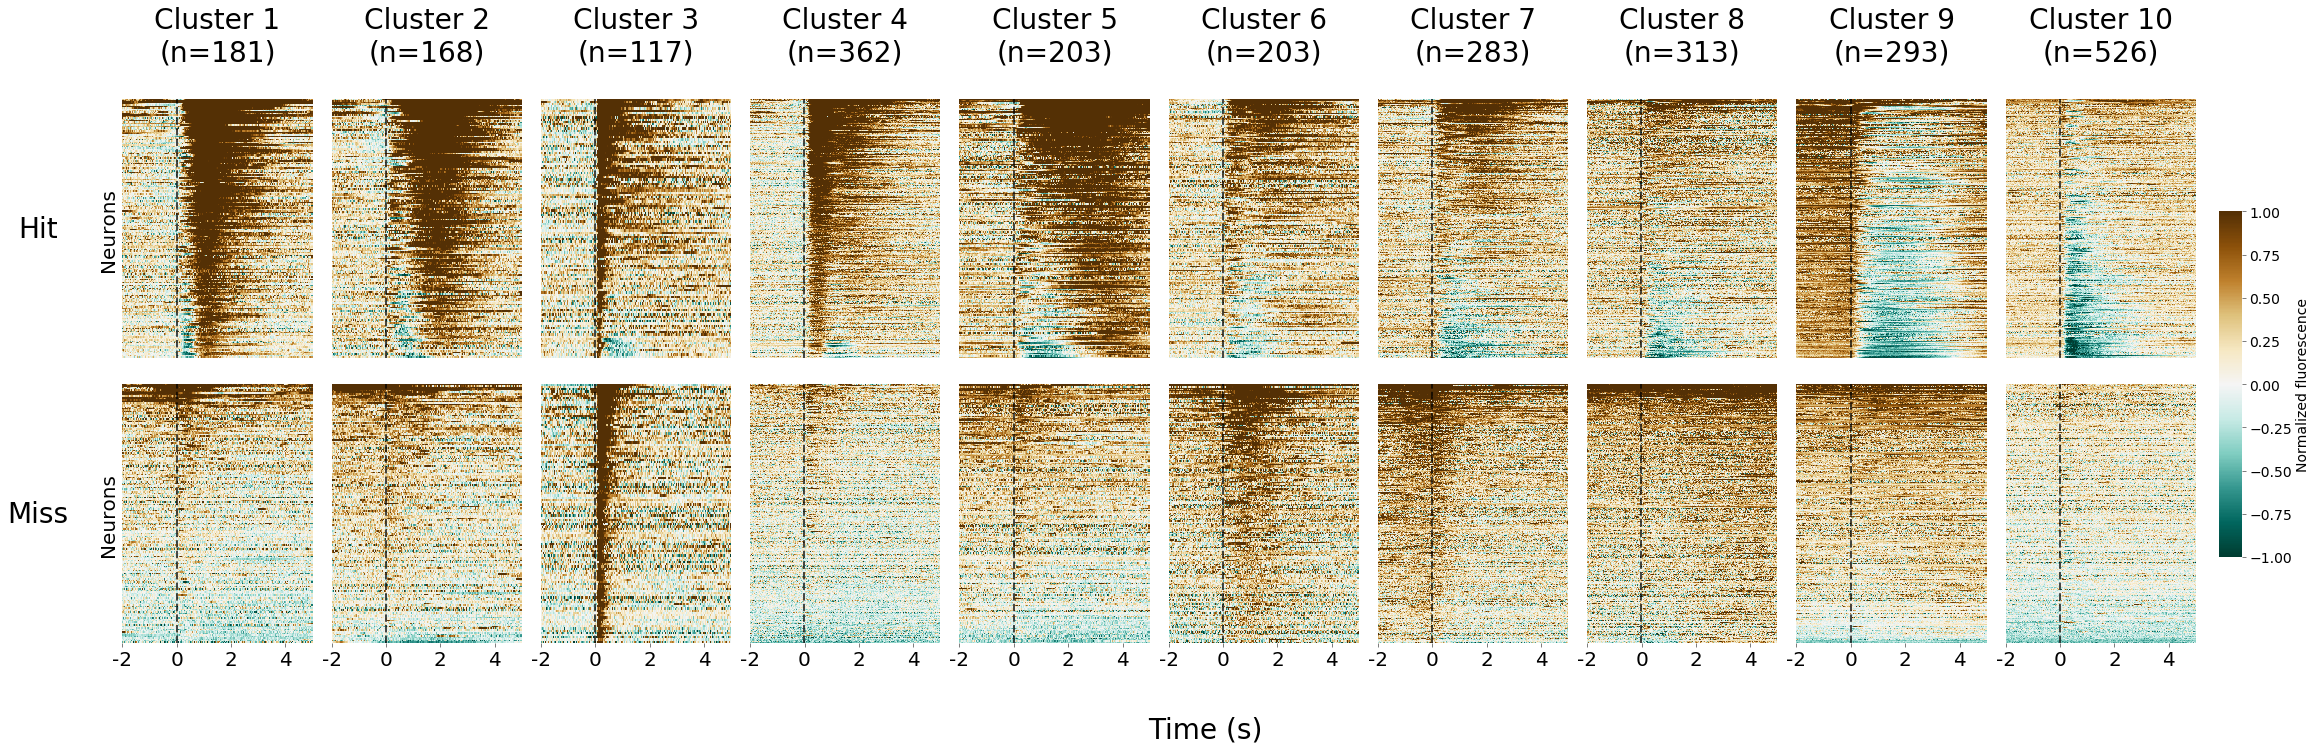

In [10]:
fig, axes = plot_clustered_heatmaps(
    population_activity=population_activity,
    cluster_labels=cluster_labels,
    n_imaging_frames_per_trial=N_IMAGING_FRAMES_PER_TRIAL,
    trial_sec=TRIAL_DURATION_SEC,
    n_pre_stim_frames=N_PRE_STIM_FRAMES,
    trial_types=TRIAL_TYPES,
    sort_window=[int((N_IMAGING_FRAMES_PER_TRIAL / TRIAL_DURATION_SEC) * 0.5), int((N_IMAGING_FRAMES_PER_TRIAL / TRIAL_DURATION_SEC) * 4)]
)

Visualise averaged response profile of each cluster

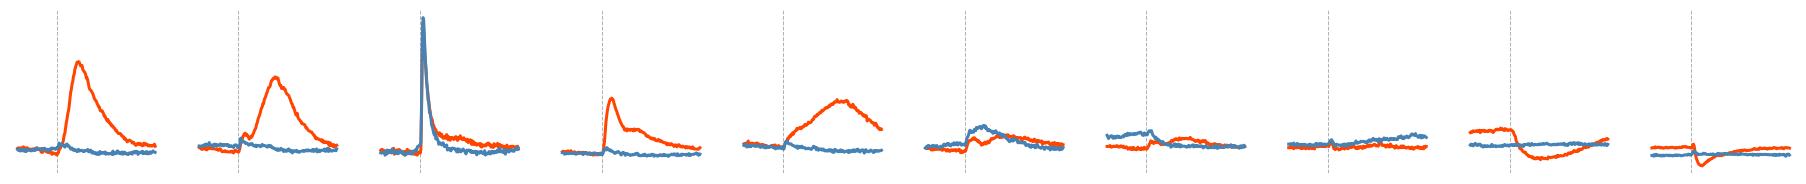

In [11]:
trial_type_colors = {'Hit': 'orangered', 'Miss': 'steelblue'}

fix, axes = plot_average_responses(
    population_activity=population_activity,
    cluster_labels=cluster_labels,
    n_imaging_frames_per_trial=N_IMAGING_FRAMES_PER_TRIAL,
    trial_types=TRIAL_TYPES,
    colors=trial_type_colors
    )